## Imports

First, we import the required libraries to do the analysis. Typical imports relevant to data analysis, visualisation, machine learning and artificial neural nets are imported below.

In [15]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [16]:
# import scoring and utility functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [17]:
# import ML regressor packages
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

In [18]:
# import the necessary keras packages for Artificial Neural Nets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

## Data Load and Preprocessing

I. Here, the supplied raw data is read and then loaded into a pandas dataframe called `data`. Subsequently some initial preprocessing is done in the form of changing the column names to more concise forms that can easily be handled. The column `sample_id` is dropped from the dataframe because it does not play a role in the determination of yield strength of the samples. Finally, the first 5 rows of the dataframe can be seen below for a cursory observation.

In [19]:
# read the raw data
data = pd.read_csv("Coding Challenge Data.csv")
data.head()

,Sample ID,Seam Type,Tensile Yield (Ksi),NDE Yield (Ksi),C (%),Mn (%),Cr (%),Cu (%),Al (%),Mo (%),Ni (%),Si (%),V (%),Grain Size (Micron)
0,Sample-1,SMLS,62.0,66.0,0.20,1.01,0.10,0.07,0.01,0.03,0.05,0.16,0.01,5.33
1,Sample-2,ERW,64.5,67.0,0.12,0.85,0.03,0.02,0.04,0.01,0.03,0.13,0.01,7.06
2,Sample-3,SMLS,55.8,53.5,0.18,1.20,0.09,0.07,0.02,0.02,0.04,0.26,0.01,6.56
3,Sample-4,ERW,76.4,75.9,0.19,0.72,0.09,0.15,0.04,0.02,0.08,0.01,0.05,4.89
4,Sample-5,ERW,51.2,57.5,0.15,0.76,0.05,0.11,0.01,0.02,0.08,0.01,0.01,14.12


In [20]:
# rename col names for easier handling
new_col_names = []
for name in data.columns:
    n_temp = "_".join(name.lower().replace("(%)", "per").split(" ")[0:2])
    new_col_names.append(n_temp)
data.columns = new_col_names

# drop the redundant sample id column
data.drop(["sample_id"], axis=1, inplace=True)

##
per_cols = [col for col in data.columns if "per" in col]
other_cols = ['grain_size','seam_type', 'nde_yield', 'tensile_yield']
data = data [per_cols + other_cols]
data.head()

,c_per,mn_per,cr_per,cu_per,al_per,mo_per,ni_per,si_per,v_per,grain_size,seam_type,nde_yield,tensile_yield
0,0.20,1.01,0.10,0.07,0.01,0.03,0.05,0.16,0.01,5.33,SMLS,66.0,62.0
1,0.12,0.85,0.03,0.02,0.04,0.01,0.03,0.13,0.01,7.06,ERW,67.0,64.5
2,0.18,1.20,0.09,0.07,0.02,0.02,0.04,0.26,0.01,6.56,SMLS,53.5,55.8
3,0.19,0.72,0.09,0.15,0.04,0.02,0.08,0.01,0.05,4.89,ERW,75.9,76.4
4,0.15,0.76,0.05,0.11,0.01,0.02,0.08,0.01,0.01,14.12,ERW,57.5,51.2


In [21]:
data['seam_type'].value_counts()

ERW     31
SMLS    13
SAW      6
Name: seam_type, dtype: int64

II. Next, we look at the datatypes of the features of the dataset. It can be observed that all features are `float64` numerical datatypes with the exception of the `seam_type` feature which is of string data type.

In [22]:
# look at the features of the dataset, also look at the distributions of the numerical features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   c_per          50 non-null     float64
 1   mn_per         50 non-null     float64
 2   cr_per         50 non-null     float64
 3   cu_per         50 non-null     float64
 4   al_per         50 non-null     float64
 5   mo_per         50 non-null     float64
 6   ni_per         50 non-null     float64
 7   si_per         50 non-null     float64
 8   v_per          50 non-null     float64
 9   grain_size     50 non-null     float64
 10  seam_type      50 non-null     object 
 11  nde_yield      50 non-null     float64
 12  tensile_yield  50 non-null     float64
dtypes: float64(12), object(1)
memory usage: 5.2+ KB


In [23]:
# observe the distributions and spead of the numerical features
data.describe()

,c_per,mn_per,cr_per,cu_per,al_per,mo_per,ni_per,si_per,v_per,grain_size,nde_yield,tensile_yield
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,0.204800,0.890400,0.053000,0.102200,0.021600,0.017000,0.07180,0.040200,0.01100,10.314800,60.356000,55.004000
std,0.060651,0.363705,0.167591,0.169493,0.016333,0.022968,0.19403,0.067928,0.01233,5.141806,11.325106,10.948338
min,0.080000,0.380000,0.000000,0.010000,0.010000,0.010000,0.01000,0.000000,0.00000,4.260000,34.100000,24.800000
25%,0.172500,0.735000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.01000,7.022500,53.050000,49.275000
50%,0.210000,0.820000,0.025000,0.035000,0.010000,0.010000,0.02000,0.010000,0.01000,9.885000,58.250000,54.900000
75%,0.240000,1.017500,0.040000,0.080000,0.030000,0.010000,0.05000,0.020000,0.01000,12.010000,66.150000,62.000000
max,0.350000,2.850000,1.200000,0.740000,0.060000,0.130000,1.03000,0.260000,0.05000,38.110000,94.900000,80.500000


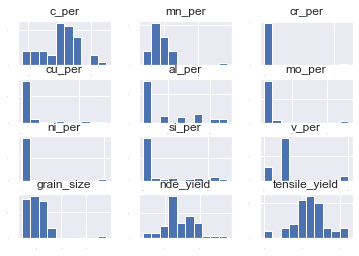

In [24]:
# observe numerical column distributions
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

III. The figure above shows the distribution or pattern of the numerical features of the dataset. For example, the figure titled `cr_per` shows the distribution of the values of the Weight percentage of corresponding chemical element (in this case Chromium) in the sample. It can be observed that many of the alloying elements have highly skewed distributions. This can often be a problem for machine learning optimization algorithms and thats why its always better to transform these features so that they are more closer to normal distributions. A typical way in statistics of doing that transformation is to apply log transformation and that is what has been applied on the numerical features below. In the next code cell, the dataset features are divided into the target variable that needs to be estimated, the numerical input features and the categorical input feature.

In [25]:
# isolate target, numerical and categorical columns
target_col = ['tensile_yield']
numerical_cols = [col for col in data.columns if data[col].dtype=='float64' and col not in target_col]
categorical_cols = [col for col in data.columns if col not in numerical_cols and col not in target_col]

IV. Below, the highly skewed numerical input feature columns are subjected to log transformation.

In [26]:
# 6. let us use a log transformation to transform the skewed features to as close as normal distributions
data_transformed = data.copy()
cols_to_transform = numerical_cols

for col in cols_to_transform:
    data_transformed[col] = data_transformed[col].apply(lambda x: np.log(x + 0.00000000001))

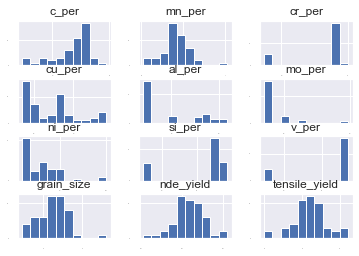

In [27]:
# observe numeric column distributions AFTER the transformation
data_transformed.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

V. The figure above shows the distributions of the input features AFTER a log transformation. It can be observed that the features now have more gaussian like distributions (not perfect) and hence are now more appropriate for fitting into machine learning models. Next, the dataset is divided into features (X) and target (Y). The column `tensile_yield` is that target feature that is to be estimated using machine learning.

In [ ]:
# split data into X's and Y's
X = data_transformed.drop(target_col, axis=1)
Y = data_transformed[target_col].values.ravel()

In [ ]:
X.shape

In [28]:
VI. Before we can fit data to machine learning models, we need to do some necessary pre-processing to the input features. The first thing to do is to standardise the numerical features such that none of the numerical features will have any extreme values that might adversely affect the convergence of the optimization algorithms behind the models. Additionally, the `seam_type` variable is a categorical one and we need numerical features for machine learning training. Hence, this variable will be subjected to one hot encoding. All these steps are performed in the code cell below.

In [29]:
X.shape

(50, 12)

VI. Before we can fit data to machine learning models, we need to do some necessary pre-processing to the input features. The first thing to do is to standardise the numerical features such that none of the numerical features will have any extreme values that might adversely affect the convergence of the optimization algorithms behind the models. Additionally, the `seam_type` variable is a categorical one and we need numerical features for machine learning training. Hence, this variable will be subjected to one hot encoding. All these steps are performed in the code cell below.

In [14]:
# create a transformer pipeline to do proper transformation to the columns
ohe = OneHotEncoder() # one hot encodes categorical columns
scaler = StandardScaler() # standardizes numerical columns for more uniform feature scaling across columns

ct = make_column_transformer(
    (ohe, categorical_cols),
    (scaler, numerical_cols),
    remainder='passthrough'
)

# do the transformation of columns
X = ct.fit_transform(X)

## ML model training

VII. Now that the input feature data is preprocessed, we can fit it to a machine learning model. The data is first split into training and validation subsets. We need to estimate `tensile_yield` which is a continuous variable and hence we have a regression task. Around 11 regression based machine learning models are initialised below and the training subset is fit to each of the models. The performance of the models is measured in terms of `Root Mean Squared Error`. Since there are only 50 samples in the dataset, there are much higher possibilities of model overfitting on the training dataset and thus a 3 fold cross validation scheme is followed during inital model training.

In [17]:
# split the dataset into train and validation sets. here we follow a 70-30% split
validation_size = 0.30 
seed = 42 
# now do the split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Evaluate an array on algorithms to decide on baseline performance
num_folds = 3
scoring = 'neg_root_mean_squared_error'

# initalise a bunch of regression algorithms for initial baseline performance 
models = [] 
models.append(('LR' ,LinearRegression())) 
models.append(('LASSO',Lasso())) 
models.append(('EN',ElasticNet())) 
models.append(('KNN',KNeighborsRegressor())) 
models.append(('DT',DecisionTreeRegressor()))
models.append(('SVR',SVR()))
models.append(('RF',RandomForestRegressor()))
models.append(('GB',ExtraTreesRegressor()))
models.append(('ET',GradientBoostingRegressor()))
models.append(('AB',AdaBoostRegressor()))
models.append(('XGB',xgb.XGBRegressor()))

In [18]:
results = [] 
names = [] 

for name, model in models: 
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results) 
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -12.227293 (2.141988)
LASSO: -8.843364 (2.467267)
EN: -8.268349 (2.090442)
KNN: -9.026135 (0.700587)
DT: -12.078802 (1.175319)
SVR: -10.070470 (1.624257)
RF: -9.583662 (1.143895)
GB: -9.706571 (1.799379)
ET: -11.183772 (1.017652)
AB: -9.948719 (1.553872)
XGB: -10.939733 (1.561472)


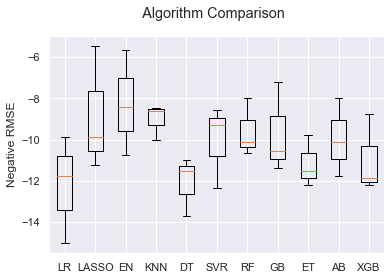

In [19]:
# Compare Algorithms 
fig = plt.figure() 
fig.suptitle(' Algorithm Comparison' ) 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
plt.ylabel("Negative RMSE")
ax.set_xticklabels(names);

## Hyperparameter Tuning and Model Optimization

VIII. From the outputs above, it can be clearly seen that the least RMSE (highest negative RMSE) is obtained for the Elastic Net Model. The distribution of the RMSE values for the model on different folds of train data shows that the Elastic Net Regressor also sometimes reaches very low RMSE values (and hence very accurate predicted values) as indicated by the upper bounds of the box plots. Therefore, the Elastic Net Regressor Model is chosen for further optimization and hyperprameter tuning at this point. Below, the Elastic Net Regressor model is tuned over a grid of different values of its hyperprameters in a 3 fold cross validation sceme.

In [20]:
# do a grid search on the Elastic Net model
param_grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], "l1_ratio": np.arange(0.0, 1.0, 0.1)}
model = ElasticNet(max_iter=10_0000)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
best_model1 = grid.best_estimator_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -8.161116 using {'alpha': 1, 'l1_ratio': 0.0}


IX. From the output above, it can be observed that a cross validation scheme with grid search has optimized the Elastic Net Regressor model further and has reduced the RMSE value on the train data set a little more. This optimized model would now be used for prediction of `tensile_yield` on the unseen validation data below.

## Prediction and Feature Importance

In [21]:
# Predict the tensile yield strength on the validation dataset
predictions = best_model1.predict(X_validation)

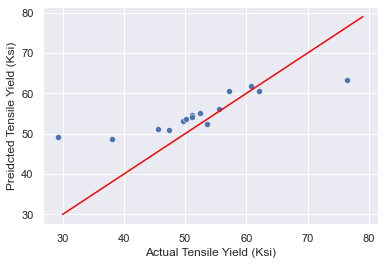

In [22]:
# plot the actual vs predicted values for the Random Forest model
sns.scatterplot(y=predictions, x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Tensile Yield (Ksi)")
plt.ylabel("Preidcted Tensile Yield (Ksi)");

In [23]:
# find out the RMSE score on the validation dataset
np.sqrt(mean_squared_error(predictions, Y_validation))

7.273686975279145

X. The model produced by the optimized Elastic Net Regressor performs well in general for most of the data points in the validation dataset although there are some extreme values where the predictions are way off from the straight line of the predicted versus actual values trend line. Now,let us look at which of the input features the Elastic Net Regressor model puts the highest importance to. It can be observed from the graph below that the `NDE_Yield`, `Grain_Size` has the highest importance followed by the `mn_per`, `c_per` features etc.

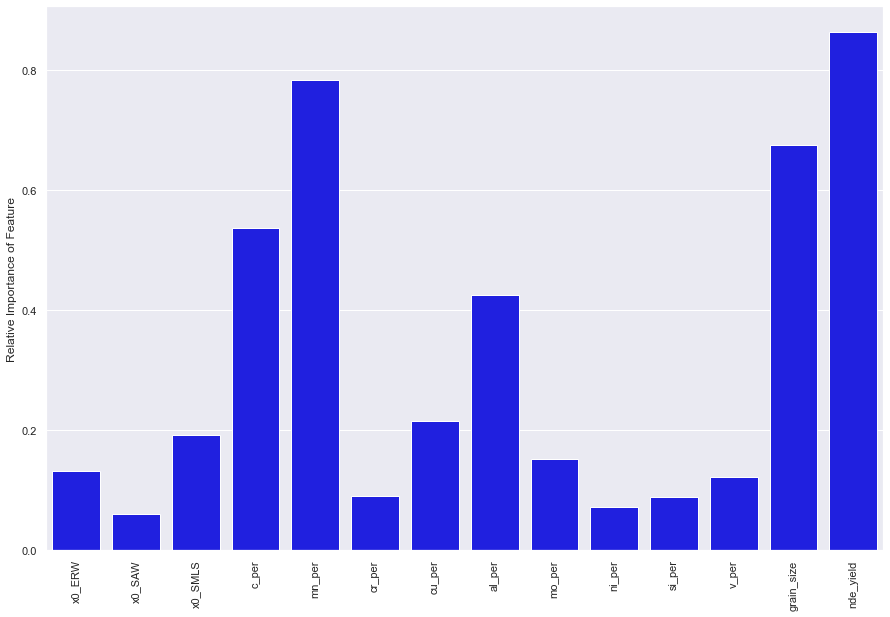

In [29]:
# Feature Importance
# get importance
importances = best_model1.coef_
importances = importances / np.sum(importances)
    
# plot feature importance
xx = [x for x in range(len(importances))]

# lets first look at the dataset the model takes as an input
one_hot_cats = list(ct.named_transformers_['onehotencoder'].get_feature_names())
all_features = one_hot_cats + numerical_cols

sns.set(font_scale=1)
f, ax = plt.subplots(1,1, figsize=(15, 10))
chart = sns.barplot(xx, np.abs(importances), ax=ax, color="blue")
chart.set_xticklabels(labels = all_features, rotation=90);
ax.set_ylabel("Relative Importance of Feature");

## Artificial Neural Nets (ANN)

XI. Below, an artificial neural network (ANN) model is trained on the data to see if they provide any additional advantage over the usual machine learning models.

In [37]:
# create the ANN model - cell type
model = Sequential()
model.add(Dense(units=32, input_shape=(X_train.shape[1],)))
model.add(Activation("relu"))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                480       
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [38]:
# init some global variables
epochs = 500
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

H = model.fit(X_train, Y_train,
              validation_data=(X_validation, Y_validation),
              verbose=1,
              epochs=epochs)

Train on 35 samples, validate on 15 samples
Epoch 1/500
35/35 [==============================] - 1s 22ms/sample - loss: 3227.2339 - mean_squared_error: 3227.2339 - val_loss: 2763.1726 - val_mean_squared_error: 2763.1726
Epoch 2/500
35/35 [==============================] - 0s 855us/sample - loss: 3221.8059 - mean_squared_error: 3221.8059 - val_loss: 2758.4094 - val_mean_squared_error: 2758.4094
Epoch 3/500
35/35 [==============================] - 0s 917us/sample - loss: 3216.7461 - mean_squared_error: 3216.7461 - val_loss: 2753.6506 - val_mean_squared_error: 2753.6506
Epoch 4/500
35/35 [==============================] - 0s 883us/sample - loss: 3211.9082 - mean_squared_error: 3211.9082 - val_loss: 2748.8816 - val_mean_squared_error: 2748.8816
Epoch 5/500
35/35 [==============================] - 0s 940us/sample - loss: 3206.9598 - mean_squared_error: 3206.9597 - val_loss: 2744.3479 - val_mean_squared_error: 2744.3479
Epoch 6/500
35/35 [==============================] - 0s 1ms/sample - los

Epoch 47/500
35/35 [==============================] - 0s 912us/sample - loss: 2996.4709 - mean_squared_error: 2996.4709 - val_loss: 2549.7334 - val_mean_squared_error: 2549.7334
Epoch 48/500
35/35 [==============================] - 0s 883us/sample - loss: 2990.6493 - mean_squared_error: 2990.6494 - val_loss: 2544.5239 - val_mean_squared_error: 2544.5239
Epoch 49/500
35/35 [==============================] - 0s 855us/sample - loss: 2984.6634 - mean_squared_error: 2984.6633 - val_loss: 2539.3018 - val_mean_squared_error: 2539.3018
Epoch 50/500
35/35 [==============================] - 0s 798us/sample - loss: 2978.8365 - mean_squared_error: 2978.8367 - val_loss: 2534.0640 - val_mean_squared_error: 2534.0640
Epoch 51/500
35/35 [==============================] - 0s 826us/sample - loss: 2972.7830 - mean_squared_error: 2972.7830 - val_loss: 2528.8213 - val_mean_squared_error: 2528.8213
Epoch 52/500
35/35 [==============================] - 0s 870us/sample - loss: 2966.8285 - mean_squared_error: 

35/35 [==============================] - 0s 684us/sample - loss: 2664.5316 - mean_squared_error: 2664.5317 - val_loss: 2254.6921 - val_mean_squared_error: 2254.6921
Epoch 94/500
35/35 [==============================] - 0s 827us/sample - loss: 2656.0131 - mean_squared_error: 2656.0132 - val_loss: 2247.0713 - val_mean_squared_error: 2247.0713
Epoch 95/500
35/35 [==============================] - 0s 684us/sample - loss: 2647.5531 - mean_squared_error: 2647.5532 - val_loss: 2239.4937 - val_mean_squared_error: 2239.4937
Epoch 96/500
35/35 [==============================] - 0s 688us/sample - loss: 2639.1902 - mean_squared_error: 2639.1902 - val_loss: 2231.9197 - val_mean_squared_error: 2231.9197
Epoch 97/500
35/35 [==============================] - 0s 855us/sample - loss: 2630.7751 - mean_squared_error: 2630.7749 - val_loss: 2224.2532 - val_mean_squared_error: 2224.2532
Epoch 98/500
35/35 [==============================] - 0s 769us/sample - loss: 2622.2909 - mean_squared_error: 2622.2908 - v

Epoch 139/500
35/35 [==============================] - 0s 798us/sample - loss: 2173.2794 - mean_squared_error: 2173.2795 - val_loss: 1837.7915 - val_mean_squared_error: 1837.7915
Epoch 140/500
35/35 [==============================] - 0s 798us/sample - loss: 2160.7216 - mean_squared_error: 2160.7217 - val_loss: 1827.5018 - val_mean_squared_error: 1827.5018
Epoch 141/500
35/35 [==============================] - 0s 741us/sample - loss: 2148.1376 - mean_squared_error: 2148.1375 - val_loss: 1817.3286 - val_mean_squared_error: 1817.3286
Epoch 142/500
35/35 [==============================] - 0s 855us/sample - loss: 2135.4698 - mean_squared_error: 2135.4700 - val_loss: 1807.0820 - val_mean_squared_error: 1807.0820
Epoch 143/500
35/35 [==============================] - 0s 712us/sample - loss: 2123.2096 - mean_squared_error: 2123.2097 - val_loss: 1796.6372 - val_mean_squared_error: 1796.6372
Epoch 144/500
35/35 [==============================] - 0s 798us/sample - loss: 2110.3392 - mean_squared_e

Epoch 185/500
35/35 [==============================] - 0s 798us/sample - loss: 1579.6846 - mean_squared_error: 1579.6846 - val_loss: 1338.1002 - val_mean_squared_error: 1338.1002
Epoch 186/500
35/35 [==============================] - 0s 712us/sample - loss: 1566.9541 - mean_squared_error: 1566.9541 - val_loss: 1327.4618 - val_mean_squared_error: 1327.4618
Epoch 187/500
35/35 [==============================] - 0s 712us/sample - loss: 1554.3359 - mean_squared_error: 1554.3359 - val_loss: 1316.7980 - val_mean_squared_error: 1316.7980
Epoch 188/500
35/35 [==============================] - 0s 655us/sample - loss: 1541.7701 - mean_squared_error: 1541.7701 - val_loss: 1306.0779 - val_mean_squared_error: 1306.0779
Epoch 189/500
35/35 [==============================] - 0s 712us/sample - loss: 1529.2180 - mean_squared_error: 1529.2181 - val_loss: 1295.3822 - val_mean_squared_error: 1295.3822
Epoch 190/500
35/35 [==============================] - 0s 855us/sample - loss: 1516.1488 - mean_squared_e

Epoch 277/500
35/35 [==============================] - 0s 769us/sample - loss: 599.5012 - mean_squared_error: 599.5012 - val_loss: 489.9217 - val_mean_squared_error: 489.9217
Epoch 278/500
35/35 [==============================] - 0s 741us/sample - loss: 591.9592 - mean_squared_error: 591.9593 - val_loss: 483.1244 - val_mean_squared_error: 483.1244
Epoch 279/500
35/35 [==============================] - 0s 769us/sample - loss: 584.4643 - mean_squared_error: 584.4643 - val_loss: 476.3288 - val_mean_squared_error: 476.3288
Epoch 280/500
35/35 [==============================] - 0s 741us/sample - loss: 576.8403 - mean_squared_error: 576.8403 - val_loss: 469.6224 - val_mean_squared_error: 469.6224
Epoch 281/500
35/35 [==============================] - 0s 769us/sample - loss: 569.1846 - mean_squared_error: 569.1846 - val_loss: 462.9423 - val_mean_squared_error: 462.9423
Epoch 282/500
35/35 [==============================] - 0s 883us/sample - loss: 561.5804 - mean_squared_error: 561.5804 - val_

Epoch 324/500
35/35 [==============================] - 0s 798us/sample - loss: 313.5660 - mean_squared_error: 313.5660 - val_loss: 239.2878 - val_mean_squared_error: 239.2878
Epoch 325/500
35/35 [==============================] - 0s 798us/sample - loss: 309.1337 - mean_squared_error: 309.1337 - val_loss: 235.4658 - val_mean_squared_error: 235.4658
Epoch 326/500
35/35 [==============================] - 0s 769us/sample - loss: 304.8709 - mean_squared_error: 304.8709 - val_loss: 231.7589 - val_mean_squared_error: 231.7589
Epoch 327/500
35/35 [==============================] - 0s 818us/sample - loss: 300.5914 - mean_squared_error: 300.5913 - val_loss: 228.1773 - val_mean_squared_error: 228.1773
Epoch 328/500
35/35 [==============================] - 0s 798us/sample - loss: 296.5427 - mean_squared_error: 296.5427 - val_loss: 224.5772 - val_mean_squared_error: 224.5772
Epoch 329/500
35/35 [==============================] - 0s 826us/sample - loss: 292.5205 - mean_squared_error: 292.5205 - val_

35/35 [==============================] - 0s 769us/sample - loss: 83.3085 - mean_squared_error: 83.3085 - val_loss: 48.8311 - val_mean_squared_error: 48.8311
Epoch 418/500
35/35 [==============================] - 0s 798us/sample - loss: 82.3737 - mean_squared_error: 82.3737 - val_loss: 48.3223 - val_mean_squared_error: 48.3223
Epoch 419/500
35/35 [==============================] - 0s 712us/sample - loss: 81.4000 - mean_squared_error: 81.4000 - val_loss: 47.8349 - val_mean_squared_error: 47.8349
Epoch 420/500
35/35 [==============================] - 0s 855us/sample - loss: 80.4631 - mean_squared_error: 80.4631 - val_loss: 47.3480 - val_mean_squared_error: 47.3480
Epoch 421/500
35/35 [==============================] - 0s 655us/sample - loss: 79.5424 - mean_squared_error: 79.5424 - val_loss: 46.8882 - val_mean_squared_error: 46.8882
Epoch 422/500
35/35 [==============================] - 0s 883us/sample - loss: 78.5866 - mean_squared_error: 78.5866 - val_loss: 46.4340 - val_mean_squared_err

35/35 [==============================] - 0s 713us/sample - loss: 54.5235 - mean_squared_error: 54.5235 - val_loss: 37.4533 - val_mean_squared_error: 37.4533
Epoch 466/500
35/35 [==============================] - 0s 741us/sample - loss: 54.1500 - mean_squared_error: 54.1500 - val_loss: 37.3472 - val_mean_squared_error: 37.3472
Epoch 467/500
35/35 [==============================] - 0s 798us/sample - loss: 53.8006 - mean_squared_error: 53.8006 - val_loss: 37.3101 - val_mean_squared_error: 37.3101
Epoch 468/500
35/35 [==============================] - 0s 855us/sample - loss: 53.4377 - mean_squared_error: 53.4377 - val_loss: 37.3034 - val_mean_squared_error: 37.3034
Epoch 469/500
35/35 [==============================] - 0s 769us/sample - loss: 53.1058 - mean_squared_error: 53.1058 - val_loss: 37.3235 - val_mean_squared_error: 37.3235
Epoch 470/500
35/35 [==============================] - 0s 883us/sample - loss: 52.7880 - mean_squared_error: 52.7880 - val_loss: 37.3540 - val_mean_squared_err

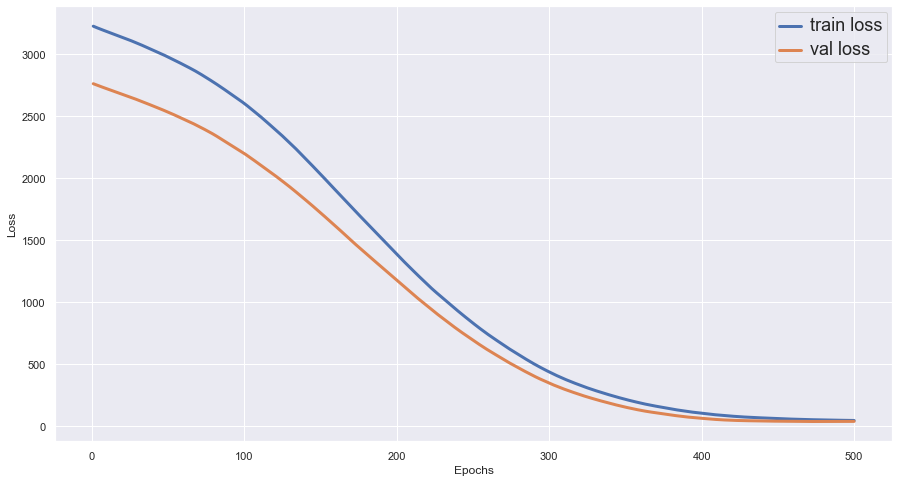

In [43]:
# plot the performance
epochs_num = range(1,epochs+1)
loss = H.history['loss']
val_loss = H.history['val_loss']

plot_df = pd.DataFrame(data=np.c_[epochs_num,loss,val_loss], 
                       columns=['epochs','loss', 'val_loss'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

XII. The graph above shows the loss i.e mean squared error trends of the ANN model over different training epochs of the model.

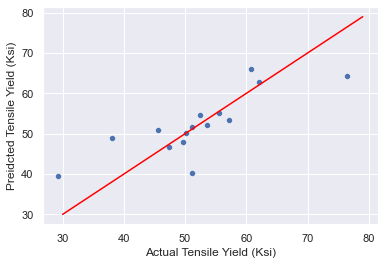

In [39]:
# use the ANN model to make predictions
ann_preds = model.predict(X_validation)

# create the plot
sns.scatterplot(y=ann_preds.ravel(), x=Y_validation)
ideal_line = list(range(30,80))
sns.lineplot(x=ideal_line, y=ideal_line, color="red")
plt.xlabel("Actual Tensile Yield (Ksi)")
plt.ylabel("Preidcted Tensile Yield (Ksi)");

In [40]:
# find out the RMSE score on the validation dataset
np.sqrt(mean_squared_error(ann_preds.ravel(), Y_validation))

6.204053209729641

XIII. From the results of the prediction of the ANN model on the validation dataset, it can be observed that the ANN model performs slightly better on the validation dataset with prediction errors on extreme values lowered in comparison to the Elastic Net regressor. This is also evident from the lower RMSE score of the ANN model on the validation dataset. Thus, the ANN model can be chosen as a predictor of the tensile yield strength if model complexity is not an issue.